In [4]:
import os
import numpy as np

In [19]:
W_TOL = 1e-20
EPS = 1e-12
EARLY_STOP_TOL = 1e-6


def calculate_fscore(M, W, H):
    """Calculates the Frobenius norm of the difference between M and WH."""
    return 0.5 * np.linalg.norm(M - np.dot(W, H), 'fro') ** 2


def calculate_gscore(W):
    """Calculates the sum of the norm of the columns of W."""
    rank = W.shape[1]
    gscore = 0
    for i in range(rank - 1):
        gscore += np.sum(np.linalg.norm(W[:, i: i + 1] - W[:, i + 1:], axis=0))
    return gscore


def calculate_hscore(W):
    """Calculates the negative sum of the minimum of each element of W and 0."""
    return -np.sum(np.minimum(W, 0))


def prox(mu, c, v):
    """Calculates the proximal operator of v with respect to mu and c."""
    vc = v - c
    return v - vc / max(1, np.linalg.norm(vc / mu))


def proj_simplex(y):
    """Projects each row of y onto the probability simplex."""
    return np.maximum(y - np.max((np.cumsum(-1 * np.sort(-y, axis=0), axis=0) - 1) /
                              np.arange(1, y.shape[0] + 1).reshape(y.shape[0], 1), axis=0), 0)


def sonnmf_with_penalty_og(M, W, H, lam=0.0, gamma=0.0, itermin=100, itermax=10000, H_update_iters=10,
                      wj_update_iters=1000, accelerate_H_update=False, early_stop=True, verbose=False):
    """
    Performs non-negative matrix factorization with penalties on W and H.

    Parameters:
    - M: the matrix to be factorized
    - W: the initial matrix for W
    - H: the initial matrix for H
    - lam: the penalty parameter for the group sparsity term
    - gamma: the penalty parameter for the non-negativity constraint on W
    - itermin: the minimum number of iterations to perform
    - itermax: the maximum number of iterations to perform
    - H_update_iters: the number of iterations to perform when updating H
    - wj_update_iters: the number of iterations to perform when updating the j-th column of W
    - early_stop: whether to use early stopping based on the change in objective function value
    - verbose: whether to print progress updates

    Returns:
    - W: the learned matrix W
    - H: the learned matrix H
    - fscores: an array of the objective function value at each iteration
    - gscores: an array of the group sparsity term value at each iteration
    - hscores: an array of the non-negativity constraint violation value at each iteration
    - total_scores: an array of the total objective function value at each iteration
    """

    m, n = M.shape
    _, rank = W.shape

    fscores = np.empty((itermax + 1,))
    gscores = np.empty((itermax + 1,))
    hscores = np.empty((itermax + 1,))
    total_scores = np.empty((itermax + 1,))

    it = 0
    fscores[it] = calculate_fscore(M, W, H)
    gscores[it] = calculate_gscore(W)
    hscores[it] = calculate_hscore(W)
    total_scores[it] = fscores[it] + lam * gscores[it] + gamma * hscores[it]
    if verbose:
        print(f'Iteration: {it}, f={fscores[it]}, g={gscores[it]}, h={hscores[it]}, total={total_scores[it]}')

    for it in range(1, itermax + 1):
        # update H
        if accelerate_H_update:
            WtW = W.T @ W
            norm_WtW = np.linalg.norm(WtW, ord=2)
            Q = np.identity(W.shape[1]) - (WtW / norm_WtW)
            R = (W.T @ M) / norm_WtW

            V = H
            for hit in range(H_update_iters):
                H_old = H
                H = proj_simplex((Q @ V) + R)
                V = H + ((it-1)/(it+2)) * (H - H_old)
        else:
            for hit in range(H_update_iters):
                H = proj_simplex(H - ((W.T @ W) @ H - W.T @ M) / np.linalg.norm(W.T @ W, ord=2))

        # update W
        ts = total_scores[it-1]
        for j in range(rank):
            hj = H[j:j + 1, :]
            hj_norm_sq = hj @ hj.T
            old_wj = wj = W[:, j:j + 1]
            for wit in range(wj_update_iters):
                Mj = M - W @ H + wj @ hj
                w_bar = (Mj @ hj.T) / (hj_norm_sq + EPS)
                alpha = (rank - 1) * lam + gamma
                prox_pen = np.median(np.hstack((w_bar + (gamma / hj_norm_sq), np.zeros((m, 1)), w_bar)), axis=1,
                                     keepdims=True)
                prox_w_sum = np.sum(
                    np.array([prox(lam / hj_norm_sq, W[:, k:k + 1], w_bar) for k in range(rank) if k != j]), axis=0)

                W[:, j:j + 1] = wj = (lam * prox_w_sum + gamma * prox_pen) / alpha
                if np.linalg.norm(wj - old_wj) / np.linalg.norm(old_wj) < W_TOL:
                    break
                old_wj = wj

            # fs = calculate_fscore(M, W, H)
            # gs = calculate_gscore(W)
            # hs = calculate_hscore(W)
            # old_ts = ts
            # ts = fs + lam * gs + gamma * hs
            # if verbose:
            #     print(f'Rank: {j}, f={fs}, g={gs}, h={hs}, total={ts}', ts <= old_ts)

        fscores[it] = calculate_fscore(M, W, H)
        gscores[it] = calculate_gscore(W)
        hscores[it] = calculate_hscore(W)
        total_scores[it] = fscores[it] + lam * gscores[it] + gamma * hscores[it]
        if verbose:
            print(f'Iteration: {it}, f={fscores[it]}, g={gscores[it]}, h={hscores[it]}, total={total_scores[it]}', total_scores[it] <= total_scores[it-1])

        if early_stop and it > itermin:
            if abs(total_scores[it] - total_scores[it - 1]) / total_scores[it - 1] < EARLY_STOP_TOL:
                print(f'Early stopping condition reached at iteration {it}.')
                break

    return W, H, fscores[:it + 1], gscores[:it + 1], hscores[:it + 1], total_scores[:it + 1]


def sonnmf_with_penalty_v2(M, W, H, lam=0.0, gamma=0.0, itermin=100, itermax=10000, H_update_iters=10, accelerate_H_update=False, early_stop=True, verbose=False):
    m, n = M.shape
    _, rank = W.shape

    fscores = np.empty((itermax + 1,))
    gscores = np.empty((itermax + 1,))
    hscores = np.empty((itermax + 1,))
    total_scores = np.empty((itermax + 1,))

    it = 0
    fscores[it] = calculate_fscore(M, W, H)
    gscores[it] = calculate_gscore(W)
    hscores[it] = calculate_hscore(W)
    total_scores[it] = fscores[it] + lam * gscores[it] + gamma * hscores[it]
    if verbose:
        print(f'Iteration: {it}, f={fscores[it]}, g={gscores[it]}, h={hscores[it]}, total={total_scores[it]}')

    for it in range(1, itermax + 1):
        # update W
        ts = total_scores[it-1]
        for j in range(rank):
            hj = H[j:j + 1, :]
            hj_norm_sq = hj @ hj.T
            wj = W[:, j:j + 1]

            Mj = M - W @ H + wj @ hj
            w_bar = (Mj @ hj.T) / (hj_norm_sq + EPS)
            alpha = (rank - 1) * lam + gamma
            prox_pen = np.median(np.hstack((w_bar + (gamma / hj_norm_sq), np.zeros((m, 1)), w_bar)), axis=1,
                                 keepdims=True)
            prox_w_sum = np.sum(
                np.array([prox(lam / hj_norm_sq, W[:, k:k + 1], w_bar) for k in range(rank) if k != j]), axis=0)

            W[:, j:j + 1] = (lam * prox_w_sum + gamma * prox_pen) / alpha

            # fs = calculate_fscore(M, W, H)
            # gs = calculate_gscore(W)
            # hs = calculate_hscore(W)
            # old_ts = ts
            # ts = fs + lam * gs + gamma * hs
            # if verbose:
            #     print(f'Rank: {j}, f={fs}, g={gs}, h={hs}, total={ts}', ts <= old_ts)

            # update H
            if accelerate_H_update:
                WtW = W.T @ W
                norm_WtW = np.linalg.norm(WtW, ord=2)
                Q = np.identity(W.shape[1]) - (WtW / norm_WtW)
                R = (W.T @ M) / norm_WtW

                V = H
                for hit in range(H_update_iters):
                    H_old = H
                    H = proj_simplex((Q @ V) + R)
                    V = H + ((it-1)/(it+2)) * (H - H_old)
            else:
                for hit in range(H_update_iters):
                    H = proj_simplex(H - ((W.T @ W) @ H - W.T @ M) / np.linalg.norm(W.T @ W, ord=2))


        fscores[it] = calculate_fscore(M, W, H)
        gscores[it] = calculate_gscore(W)
        hscores[it] = calculate_hscore(W)
        total_scores[it] = fscores[it] + lam * gscores[it] + gamma * hscores[it]
        if verbose:
            print(f'Iteration: {it}, f={fscores[it]}, g={gscores[it]}, h={hscores[it]}, total={total_scores[it]}', total_scores[it] <= total_scores[it-1])

        if early_stop and it > itermin:
            if abs(total_scores[it] - total_scores[it - 1]) / total_scores[it - 1] < EARLY_STOP_TOL:
                print(f'Early stopping condition reached at iteration {it}.')
                break

    return W, H, fscores[:it + 1], gscores[:it + 1], hscores[:it + 1], total_scores[:it + 1]


def sonnmf_with_penalty_v3(M, W, H, lam=0.0, gamma=0.0, itermin=100, itermax=10000, H_update_iters=10,
                      W_update_iters=1000, accelerate_H_update=False, early_stop=True, verbose=False):
    """
    Performs non-negative matrix factorization with penalties on W and H.

    Parameters:
    - M: the matrix to be factorized
    - W: the initial matrix for W
    - H: the initial matrix for H
    - lam: the penalty parameter for the group sparsity term
    - gamma: the penalty parameter for the non-negativity constraint on W
    - itermin: the minimum number of iterations to perform
    - itermax: the maximum number of iterations to perform
    - H_update_iters: the number of iterations to perform when updating H
    - wj_update_iters: the number of iterations to perform when updating the j-th column of W
    - early_stop: whether to use early stopping based on the change in objective function value
    - verbose: whether to print progress updates

    Returns:
    - W: the learned matrix W
    - H: the learned matrix H
    - fscores: an array of the objective function value at each iteration
    - gscores: an array of the group sparsity term value at each iteration
    - hscores: an array of the non-negativity constraint violation value at each iteration
    - total_scores: an array of the total objective function value at each iteration
    """

    m, n = M.shape
    _, rank = W.shape

    fscores = np.empty((itermax + 1,))
    gscores = np.empty((itermax + 1,))
    hscores = np.empty((itermax + 1,))
    total_scores = np.empty((itermax + 1,))

    it = 0
    fscores[it] = calculate_fscore(M, W, H)
    gscores[it] = calculate_gscore(W)
    hscores[it] = calculate_hscore(W)
    total_scores[it] = fscores[it] + lam * gscores[it] + gamma * hscores[it]
    if verbose:
        print(f'Iteration: {it}, f={fscores[it]}, g={gscores[it]}, h={hscores[it]}, total={total_scores[it]}')

    for it in range(1, itermax + 1):
        # update H
        if accelerate_H_update:
            WtW = W.T @ W
            norm_WtW = np.linalg.norm(WtW, ord=2)
            Q = np.identity(W.shape[1]) - (WtW / norm_WtW)
            R = (W.T @ M) / norm_WtW

            V = H
            for hit in range(H_update_iters):
                H_old = H
                H = proj_simplex((Q @ V) + R)
                V = H + ((it-1)/(it+2)) * (H - H_old)
        else:
            for hit in range(H_update_iters):
                H = proj_simplex(H - ((W.T @ W) @ H - W.T @ M) / np.linalg.norm(W.T @ W, ord=2))

        # update W
        for wit in range(W_update_iters):
            ts = total_scores[it-1]
            for j in range(rank):
                hj = H[j:j + 1, :]
                hj_norm_sq = hj @ hj.T
                wj = W[:, j:j + 1]

                Mj = M - W @ H + wj @ hj
                w_bar = (Mj @ hj.T) / (hj_norm_sq + EPS)
                alpha = (rank - 1) * lam + gamma
                prox_pen = np.median(np.hstack((w_bar + (gamma / hj_norm_sq), np.zeros((m, 1)), w_bar)), axis=1,
                                     keepdims=True)
                prox_w_sum = np.sum(
                    np.array([prox(lam / hj_norm_sq, W[:, k:k + 1], w_bar) for k in range(rank) if k != j]), axis=0)

                W[:, j:j + 1] = wj = (lam * prox_w_sum + gamma * prox_pen) / alpha

                # fs = calculate_fscore(M, W, H)
                # gs = calculate_gscore(W)
                # hs = calculate_hscore(W)
                # old_ts = ts
                # ts = fs + lam * gs + gamma * hs
                # if verbose:
                #     print(f'Rank: {j}, f={fs}, g={gs}, h={hs}, total={ts}', ts <= old_ts)

        fscores[it] = calculate_fscore(M, W, H)
        gscores[it] = calculate_gscore(W)
        hscores[it] = calculate_hscore(W)
        total_scores[it] = fscores[it] + lam * gscores[it] + gamma * hscores[it]
        if verbose:
            print(f'Iteration: {it}, f={fscores[it]}, g={gscores[it]}, h={hscores[it]}, total={total_scores[it]}', total_scores[it] <= total_scores[it-1])

        if early_stop and it > itermin:
            if abs(total_scores[it] - total_scores[it - 1]) / total_scores[it - 1] < EARLY_STOP_TOL:
                print(f'Early stopping condition reached at iteration {it}.')
                break

    return W, H, fscores[:it + 1], gscores[:it + 1], hscores[:it + 1], total_scores[:it + 1]


In [20]:
data_filepath = f'../datasets/synthetic_data.npz'

data = np.load(data_filepath)
M = data['M']
W_true = data['W_true']
H_true = data['H_true']

In [21]:
m, n = M.shape
max_iters = 10000
r = 8
ini_filepath = f'../../experimental/saved_models/synthetic/r{r}_ini.npz'

if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath, 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

### Original, with l_max = 10, w_j iters = 1000, accelarated h

In [41]:
maxit = 1000
h_its = 1
w_its = 100
h_acc = True

In [42]:
# full
_, _, _, _, _, F1 = sonnmf_with_penalty_v3(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=1, W_update_iters=100, accelerate_H_update=h_acc, verbose=True, early_stop=False)


Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=98.72558939666243, g=4.862834592834916, h=-0.0, total=103.58842398949734 True
Iteration: 2, f=96.51701844811834, g=8.905178634727488, h=-0.0, total=105.42219708284583 False
Iteration: 3, f=89.8729654069417, g=16.636481093333977, h=0.1614947374144106, total=106.6709412376901 False
Iteration: 4, f=70.64173988083654, g=30.310314237267086, h=0.9903016831375918, total=101.94235580124122 True
Iteration: 5, f=34.16665500976031, g=45.86957553352747, h=2.554185605738511, total=82.5904161490263 True
Iteration: 6, f=11.324451513961503, g=54.38300858080814, h=3.5862217269797334, total=69.29368182174937 True
Iteration: 7, f=4.699175270632274, g=57.858733339953346, h=4.045360325592788, total=66.60326893617841 True
Iteration: 8, f=2.4423914085799034, g=59.27965482930029, h=4.252675316824819, total=65.97472155470501 True
Iteration: 9, f=1.545289327787427, g=59.726011392606615, h=4.331117911246425, 

In [43]:
# only H
_, _, _, _, _, F2 = sonnmf_with_penalty_v3(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=100, W_update_iters=1, accelerate_H_update=h_acc, verbose=True, early_stop=False)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=10.73477088117682, g=31.76243051859165, h=0.7111177119467322, total=43.208319111715205 True
Iteration: 2, f=0.8660841881121801, g=33.09223839099318, h=0.7842865805410629, total=34.74260915964643 True
Iteration: 3, f=0.385698462095435, g=33.00132658350281, h=0.7562552940155167, total=34.14328033961376 True
Iteration: 4, f=0.25973449780355906, g=32.62121233964647, h=0.7169461821169618, total=33.59789301956699 True
Iteration: 5, f=0.19546859798102106, g=32.16222972103845, h=0.676775768833781, total=33.03447408785325 True
Iteration: 6, f=0.15909596264165501, g=31.683944535124198, h=0.6401812534468657, total=32.48322175121272 True
Iteration: 7, f=0.13993402661328247, g=31.21439463766153, h=0.5993907977192149, total=31.95371946199403 True
Iteration: 8, f=0.13339521736276494, g=30.766482459919377, h=0.5746545494145546, total=31.474532226696695 True
Iteration: 9, f=0.1342540651366552, g=30.

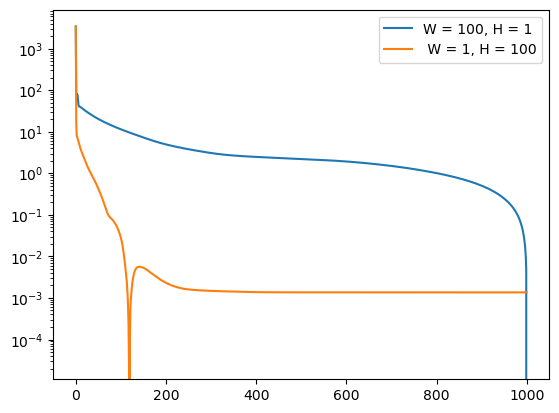

In [44]:
import matplotlib.pyplot as plt

min_val = min(min(F1), min(F2))

plt.plot(F1 - min(F1))
plt.plot(F2 - min(F2))

plt.yscale('log')
plt.legend(['W = 100, H = 1', ' W = 1, H = 100'])

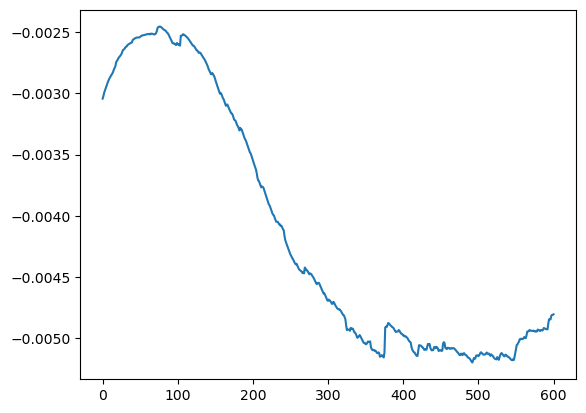

In [50]:
plt.plot(F1[400:] - F1[399:-1])
# plt.yscale('log')


In [22]:
# only W
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Iteration: 2, f=421.654126534797, g=44.8708108982782, h=7.573974593543736, total=474.0989120266189 True
Iteration: 3, f=305.2151763334047, g=37.80248123270102, h=6.052413445694957, total=349.07007101180074 True
Iteration: 4, f=239.74803683938316, g=31.568690403375502, h=4.785579859237535, total=276.1023071019962 True
Iteration: 5, f=200.14656654986015, g=26.7127555329373, h=3.5366359446349738, total=230.39595802743244 True
Iteration: 6, f=174.70379231585287, g=22.890225063849677, h=2.5790543245204915, total=200.17307170422302 True
Iteration: 7, f=157.62115432162614, g=20.200787663046896, h=2.1293702538893364, total=179.95131223856237 True
Iteration: 8, f=145.7662546618795, g=17.90683292097687, h=1.7653350450136072, total=165.43842262786998 True
Iteration: 9, f=137.26178216043652, g=16.0405125473

In [34]:
# only W, each column
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Rank: 0, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Rank: 1, f=664.5454347578831, g=54.8634738678406, h=9.310252051353768, total=728.7191606770775 True
Rank: 2, f=656.5323064280038, g=54.7223561974541, h=9.310252051353768, total=720.5649146768118 True
Rank: 3, f=656.3906772130147, g=54.7441699549883, h=9.310252051353768, total=720.4450992193567 True
Rank: 4, f=654.4035856360031, g=54.08895356922149, h=9.310252051353768, total=717.8027912565784 True
Rank: 5, f=653.1870772466423, g=53.72772963200892, h=9.310252051353768, total=716.225058930005 True
Rank: 6, f=650.6003797892724, g=52.84401728021533, h=9.310252051353768, total=712.7546491208416 True
Rank: 7, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Iteration: 1, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Ra

In [39]:
# only W, 1 column
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Rank: 0, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Iteration: 1, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 2, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 3, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 4, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887

### Original, with l_max = 10, w_j iters = 1, accelarated h == Algorith 4

In [40]:
maxit = 20
h_its = 20
w_its = 1
h_acc = True

In [8]:
# full
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=18.853080217934565, g=38.26005929014176, h=1.275659481507914, total=58.388798989584245 True
Iteration: 2, f=0.8400798751380647, g=38.83226964305165, h=1.302127657121858, total=40.97447717531158 True
Iteration: 3, f=0.2572936941510702, g=38.12757112362157, h=1.2372038578391487, total=39.62206867561179 True
Iteration: 4, f=0.16375277700075613, g=37.229927498972465, h=1.171136661517318, total=38.56481693749054 True
Iteration: 5, f=0.1388160691417856, g=36.33984824006108, h=1.1104584712320693, total=37.589122780434934 True
Iteration: 6, f=0.133452945135165, g=35.49523902998519, h=1.0576219806108327, total=36.686313955731194 True
Iteration: 7, f=0.13503069756968417, g=34.69263675006731, h=1.0116415700901253, total=35.83930901772712 True
Iteration: 8, f=0.13803653073205277, g=33.91985593716358, h=0.970935293459958, total=35.02882776135559 True
Iteration: 9, f=0.13923683575956525, g=33.176

In [17]:
# only H
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=57.799032031867675, g=19.41704056555455, h=-0.0, total=77.21607259742223 True
Iteration: 2, f=47.74748281564629, g=19.41704056555455, h=-0.0, total=67.16452338120084 True
Iteration: 3, f=44.51036543354263, g=19.41704056555455, h=-0.0, total=63.92740599909718 True
Iteration: 4, f=43.12622130490875, g=19.41704056555455, h=-0.0, total=62.543261870463304 True
Iteration: 5, f=42.65265203591255, g=19.41704056555455, h=-0.0, total=62.0696926014671 True
Iteration: 6, f=42.50560475178959, g=19.41704056555455, h=-0.0, total=61.92264531734414 True
Iteration: 7, f=42.4432865565482, g=19.41704056555455, h=-0.0, total=61.86032712210275 True
Iteration: 8, f=42.414601608796204, g=19.41704056555455, h=-0.0, total=61.831642174350755 True
Iteration: 9, f=42.399314268646265, g=19.41704056555455, h=-0.0, total=61.816354834200816 True
Iteration: 10, f=42.390890506052166, g=19.41704056555455, h=-0.0, tota

In [24]:
# only W
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Iteration: 2, f=421.654126534797, g=44.8708108982782, h=7.573974593543736, total=474.0989120266189 True
Iteration: 3, f=305.2151763334047, g=37.80248123270102, h=6.052413445694957, total=349.07007101180074 True
Iteration: 4, f=239.74803683938316, g=31.568690403375502, h=4.785579859237535, total=276.1023071019962 True
Iteration: 5, f=200.14656654986015, g=26.7127555329373, h=3.5366359446349738, total=230.39595802743244 True
Iteration: 6, f=174.70379231585287, g=22.890225063849677, h=2.5790543245204915, total=200.17307170422302 True
Iteration: 7, f=157.62115432162614, g=20.200787663046896, h=2.1293702538893364, total=179.95131223856237 True
Iteration: 8, f=145.7662546618795, g=17.90683292097687, h=1.7653350450136072, total=165.43842262786998 True
Iteration: 9, f=137.26178216043652, g=16.0405125473

In [32]:
# only W, each column
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Rank: 0, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Rank: 1, f=664.5454347578831, g=54.8634738678406, h=9.310252051353768, total=728.7191606770775 True
Rank: 2, f=656.5323064280038, g=54.7223561974541, h=9.310252051353768, total=720.5649146768118 True
Rank: 3, f=656.3906772130147, g=54.7441699549883, h=9.310252051353768, total=720.4450992193567 True
Rank: 4, f=654.4035856360031, g=54.08895356922149, h=9.310252051353768, total=717.8027912565784 True
Rank: 5, f=653.1870772466423, g=53.72772963200892, h=9.310252051353768, total=716.225058930005 True
Rank: 6, f=650.6003797892724, g=52.84401728021533, h=9.310252051353768, total=712.7546491208416 True
Rank: 7, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Iteration: 1, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Ra

In [41]:
# only W, 1 column
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Rank: 0, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Iteration: 1, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 2, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 3, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 4, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887

### Algorithm 5, with l_max = 10, accelarated h

In [42]:
maxit = 20
h_its = 20
h_acc = True

In [10]:
# full
_, _, _, _, _, _ = sonnmf_with_penalty_v2(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=3.3750645766060483, g=64.23183099077052, h=9.40966752118889, total=77.01656308856546 True
Iteration: 2, f=0.976374918082914, g=34.35260451399632, h=0.9281596946514009, total=36.25713912673063 True
Iteration: 3, f=0.5763224574539119, g=32.99822023583773, h=1.0249386748869616, total=34.5994813681786 True
Iteration: 4, f=0.40359716559968795, g=32.363143311159334, h=1.0533380198776778, total=33.8200784966367 True
Iteration: 5, f=0.31315209405649586, g=31.875757282853638, h=1.0493900561486085, total=33.23829943305874 True
Iteration: 6, f=0.26082249958797776, g=31.414211877626116, h=1.0279872473855973, total=32.70302162459969 True
Iteration: 7, f=0.2315982248135523, g=30.966506109792313, h=1.0094134391269036, total=32.20751777373277 True
Iteration: 8, f=0.2156148528990418, g=30.570246754902023, h=0.9928947613378653, total=31.77875636913893 True
Iteration: 9, f=0.20734596020435592, g=30.18

In [19]:
# only H
_, _, _, _, _, _ = sonnmf_with_penalty_v2(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=42.658697232764254, g=19.41704056555455, h=-0.0, total=62.075737798318805 True
Iteration: 2, f=42.40302626764611, g=19.41704056555455, h=-0.0, total=61.82006683320066 True
Iteration: 3, f=42.3832734786887, g=19.41704056555455, h=-0.0, total=61.80031404424325 True
Iteration: 4, f=42.38039248073367, g=19.41704056555455, h=-0.0, total=61.79743304628822 True
Iteration: 5, f=42.37986233878605, g=19.41704056555455, h=-0.0, total=61.7969029043406 True
Iteration: 6, f=42.37973675859996, g=19.41704056555455, h=-0.0, total=61.79677732415451 True
Iteration: 7, f=42.379665305453045, g=19.41704056555455, h=-0.0, total=61.796705871007596 True
Iteration: 8, f=42.37960344247387, g=19.41704056555455, h=-0.0, total=61.79664400802842 True
Iteration: 9, f=42.37954276278852, g=19.41704056555455, h=-0.0, total=61.79658332834307 True
Iteration: 10, f=42.37948748728325, g=19.41704056555455, h=-0.0, total=6

In [26]:
# only W
_, _, _, _, _, _ = sonnmf_with_penalty_v2(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Iteration: 2, f=421.654126534797, g=44.8708108982782, h=7.573974593543736, total=474.0989120266189 True
Iteration: 3, f=305.2151763334047, g=37.80248123270102, h=6.052413445694957, total=349.07007101180074 True
Iteration: 4, f=239.74803683938316, g=31.568690403375502, h=4.785579859237535, total=276.1023071019962 True
Iteration: 5, f=200.14656654986015, g=26.7127555329373, h=3.5366359446349738, total=230.39595802743244 True
Iteration: 6, f=174.70379231585287, g=22.890225063849677, h=2.5790543245204915, total=200.17307170422302 True
Iteration: 7, f=157.62115432162614, g=20.200787663046896, h=2.1293702538893364, total=179.95131223856237 True
Iteration: 8, f=145.7662546618795, g=17.90683292097687, h=1.7653350450136072, total=165.43842262786998 True
Iteration: 9, f=137.26178216043652, g=16.0405125473

In [36]:
# only W, each column
_, _, _, _, _, _ = sonnmf_with_penalty_v2(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Rank: 0, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Rank: 1, f=664.5454347578831, g=54.8634738678406, h=9.310252051353768, total=728.7191606770775 True
Rank: 2, f=656.5323064280038, g=54.7223561974541, h=9.310252051353768, total=720.5649146768118 True
Rank: 3, f=656.3906772130147, g=54.7441699549883, h=9.310252051353768, total=720.4450992193567 True
Rank: 4, f=654.4035856360031, g=54.08895356922149, h=9.310252051353768, total=717.8027912565784 True
Rank: 5, f=653.1870772466423, g=53.72772963200892, h=9.310252051353768, total=716.225058930005 True
Rank: 6, f=650.6003797892724, g=52.84401728021533, h=9.310252051353768, total=712.7546491208416 True
Rank: 7, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Iteration: 1, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Ra

In [43]:
# only W, 1 column
_, _, _, _, _, _ = sonnmf_with_penalty_v2(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Rank: 0, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Iteration: 1, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 2, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 3, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 4, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887

### Original, with l_max = 1, w_j iters = 1, accelarated h = FALSE --> Simplest


In [52]:
maxit = 20
h_its = 1
w_its = 1
h_acc = False

In [53]:
# full
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=99.51250722896887, g=8.910756214830311, h=-0.0, total=108.42326344379919 True
Iteration: 2, f=94.75172273740705, g=11.075438716802235, h=-0.0, total=105.82716145420929 True
Iteration: 3, f=85.75822598431978, g=18.611628927797288, h=0.1980708789618723, total=104.56792579107893 True
Iteration: 4, f=64.65132730881605, g=30.694261333795264, h=1.0765332977836644, total=96.42212194039499 True
Iteration: 5, f=33.0526508928372, g=43.55523330250668, h=2.405736773066086, total=79.01362096840995 True
Iteration: 6, f=12.055719625349314, g=51.797008554392505, h=3.2438388144121904, total=67.096566994154 True
Iteration: 7, f=5.574725255653193, g=55.640281025685645, h=3.6998485882877077, total=64.91485486962654 True
Iteration: 8, f=3.1313777330518775, g=57.59430825791083, h=3.9769083977973905, total=64.7025943887601 True
Iteration: 9, f=1.99256289488366, g=58.610759543802025, h=4.134015453922761, t

In [55]:
# only H
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=108.8252205647873, g=19.41704056555455, h=-0.0, total=128.24226113034186 True
Iteration: 2, f=102.74185215328845, g=19.41704056555455, h=-0.0, total=122.15889271884299 True
Iteration: 3, f=97.28689535745242, g=19.41704056555455, h=-0.0, total=116.70393592300698 True
Iteration: 4, f=92.3908778741738, g=19.41704056555455, h=-0.0, total=111.80791843972835 True
Iteration: 5, f=88.02717841944956, g=19.41704056555455, h=-0.0, total=107.44421898500411 True
Iteration: 6, f=84.12731250355273, g=19.41704056555455, h=-0.0, total=103.54435306910727 True
Iteration: 7, f=80.66247080323882, g=19.41704056555455, h=-0.0, total=100.07951136879336 True
Iteration: 8, f=77.58435066224406, g=19.41704056555455, h=-0.0, total=97.00139122779862 True
Iteration: 9, f=74.81349520322651, g=19.41704056555455, h=-0.0, total=94.23053576878107 True
Iteration: 10, f=72.3289407079902, g=19.41704056555455, h=-0.0, tot

In [57]:
# only W
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Iteration: 1, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Iteration: 2, f=421.654126534797, g=44.8708108982782, h=7.573974593543736, total=474.0989120266189 True
Iteration: 3, f=305.2151763334047, g=37.80248123270102, h=6.052413445694957, total=349.07007101180074 True
Iteration: 4, f=239.74803683938316, g=31.568690403375502, h=4.785579859237535, total=276.1023071019962 True
Iteration: 5, f=200.14656654986015, g=26.7127555329373, h=3.5366359446349738, total=230.39595802743244 True
Iteration: 6, f=174.70379231585287, g=22.890225063849677, h=2.5790543245204915, total=200.17307170422302 True
Iteration: 7, f=157.62115432162614, g=20.200787663046896, h=2.1293702538893364, total=179.95131223856237 True
Iteration: 8, f=145.7662546618795, g=17.90683292097687, h=1.7653350450136072, total=165.43842262786998 True
Iteration: 9, f=137.26178216043652, g=16.0405125473

In [59]:
# only W, each column
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Rank: 0, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Rank: 1, f=664.5454347578831, g=54.8634738678406, h=9.310252051353768, total=728.7191606770775 True
Rank: 2, f=656.5323064280038, g=54.7223561974541, h=9.310252051353768, total=720.5649146768118 True
Rank: 3, f=656.3906772130147, g=54.7441699549883, h=9.310252051353768, total=720.4450992193567 True
Rank: 4, f=654.4035856360031, g=54.08895356922149, h=9.310252051353768, total=717.8027912565784 True
Rank: 5, f=653.1870772466423, g=53.72772963200892, h=9.310252051353768, total=716.225058930005 True
Rank: 6, f=650.6003797892724, g=52.84401728021533, h=9.310252051353768, total=712.7546491208416 True
Rank: 7, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Iteration: 1, f=645.938241858652, g=52.72608425029136, h=9.310252051353768, total=707.9745781602971 True
Ra

In [61]:
# only W, 1 column
_, _, _, _, _, _ = sonnmf_with_penalty_og(M, ini_W.copy(), ini_H.copy(), lam=1, gamma=1, itermax=maxit, H_update_iters=h_its, wj_update_iters=w_its, accelerate_H_update=h_acc, verbose=True)

Iteration: 0, f=3440.3020958216766, g=19.41704056555455, h=-0.0, total=3459.719136387231
Rank: 0, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Iteration: 1, f=826.9160334246295, g=51.495521828163106, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 2, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 3, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Iteration: 4, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887.1852762011264 True
Rank: 0, f=826.9160334246295, g=51.49552182816309, h=8.773720948333843, total=887